# Финальный проект. Анализ оттока клиентов банка

# Материалы

**Презентация** - https://disk.yandex.ru/i/f6QX_aULG2yF4w

**Дашборд** - https://public.tableau.com/app/profile/grigoriy3340/viz/___16618826404430/Dashboard1?publish=yes

**Описание проекта:**

Необходимо проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

**Описание данных:**

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

**Декомпозация (задачи проекта):**

1. Загрузка данных и первый взгляд.
2. Предобработка данных:
 - приведение названий строк/столбцов к единому регистру;
 - проверка на пропуски, дубликаты.
3. Исследовательский анализ данных EDA.
4. Портрет клиентов, склонных уходить из банка.
5. Формулировка и проверка гиппотез:
 - гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались;
 - гипотеза различия возраста между теми клиентами, которые ушли и теми, которые остались.
6. Общий вывод и рекомендации.

## Загрузка данных

In [1]:
# импортируем нужные нам в проекте библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st


import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузим данные и сохраним в переменной df
df = pd.read_csv('/datasets/bank_dataset.csv')

In [3]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


**Вывод:**

Датасет состоит из 12 столбцов и 10 000 строк. По столбцу `Balance` (баланс на карте) видны попуски - либо у клиентов нет денег на картах, либо связано с технической неполадкой выгрузки данных.

Необходимо разобраться со следующими моментами:
- привести названия колонок к нижнему регистру
- подумать над необходимостью заполнения пропусков
- проверить наличие дубликатов  
- заменить тип данных в столбцах `gender` и `city`, из категориальных в колличественные

## Предобработка данных

Приведем названия столбцов в нижнему регистру.

In [5]:
df.columns = df.columns.str.lower()
df.head(1)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1


Займемся пропусками. 

In [6]:
df.isna().sum()

userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

3617 пропуска - это больше трети от всех значений. Посмотрим, как распределены пропуски в столбце баланс и попробуем найти зависимость.

In [7]:
df[df['balance'].isna()]['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

In [8]:
df[df['balance'].isna()]['creditcard'].value_counts()

1    2592
0    1025
Name: creditcard, dtype: int64

In [9]:
df[df['balance'].isna()]['products'].value_counts()

2    2600
1     905
3      98
4      14
Name: products, dtype: int64

In [10]:
df[df['balance'].isna()]['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

Итак пропущенные значения баланса оказались:
- только двух городах (Ярославль и Рыбинск),
- у держателей кредитных карт пропусков больше в 2.5 раза, 
- у пользователей двух продуктов больше всего пропусков, 
- в категории "оставшихся в банке" клиентов в 6.2 раза больше пропущенных значений. 

По логике баланс может быть как положительным, нулевым, либо вообще отрицательным. Можно было бы заполнить пропуски нулями, но для этого следует уточнить природу их возникновения у тех, кто передал данные. 

В виду невозможности этого сделать, пропущенные значения оставим, как есть.

Проверим наличие дубликатов.

In [11]:
df.duplicated().sum()

0

Дубликаты не обнаружены.

Для проведения дальнейшего корректного анализа, в том числе корреляционного, категориальные переменные в `gender` и `city` меняем на колличественные. 

In [12]:
df.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [13]:
# используем метод One-Hot Encoding
df = pd.get_dummies(df)
df

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,15677338,619,42,2,NaN,1,1,1,101348.88,1,0,0,1,1,0
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,15744090,699,39,1,NaN,2,0,0,93826.63,0,0,0,1,1,0
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,39,5,NaN,2,1,0,96270.64,0,0,0,1,0,1
9996,15612628,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9997,15627268,709,36,7,NaN,1,0,1,42085.58,1,0,0,1,1,0
9998,15725091,772,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


**Вывод:** 

* Названия столбцов приведены к единому регистру - нижнему.
* Пропуски обнаружены по столбцу `balance`, принято решение пока оставить как есть.
* Дубликаты не обнаружены.
* Заменены типы данных в столбцах `gender` и `city`.

## Исследовательский анализ данных EDA

### Анализ средних значений признаков и стандартного отклонения без разреза по оттоку

Посмотрим на распределение значений. Применим функцию `describe`.

In [14]:
df.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.501400,0.454300,0.545700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.500023,0.497932,0.497932
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Предварительный вывод**
* все клиенты уникальные, всего 10 000 чел.
* в среднем, кредитный рейтинг нелохой - 650 и практически равен медианному
* все клиенты совершеннолетние, возрастом от 18 до 92 лет, средний возраст 39 лет
* у большинства клиентов в собственности 5 объектов
* среднее количество денег на счете равно 119 тыс. 
* клиенты пользуются 1-2 продуктами банка
* большинство имеют кредитную карту
* активность проявляют чуть больше половины клиентов
* средний отток составляет 20%, что довольно много
* по географии распределения клиентов: половина всех живет в Ярославле, еще по четверти в Ростове Великом и Рыбинске
* мужчин немного больше - на 4.5%

Больше всего вопросов вызывает подозрительно низкая граница заработной платы клиентов. Рассмотрим поподробней этот момент.

In [15]:
df.sort_values('estimated_salary').head(10)

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
2362,15833789,709,45,4,122917.71,1,1,1,11.58,1,1,0,0,0,1
9647,15722429,625,31,5,NaN,2,0,1,90.07,0,0,0,1,0,1
9010,15829199,645,59,8,121669.93,2,0,0,91.75,1,1,0,0,1,0
5548,15682398,710,38,2,NaN,2,1,0,96.27,0,0,0,1,0,1
4989,15645587,629,40,9,NaN,1,1,0,106.67,0,0,0,1,0,1
7565,15666105,708,52,10,105355.81,1,1,0,123.07,1,0,0,1,0,1
2498,15691471,718,37,8,NaN,2,1,1,142.81,0,0,0,1,0,1
8722,15761403,621,35,7,87619.29,1,1,0,143.34,0,0,0,1,0,1
4774,15683157,811,35,7,NaN,1,1,1,178.19,0,0,0,1,1,0
1451,15726934,551,38,10,NaN,2,1,1,216.27,0,0,0,1,1,0


Сразу заметим, что у большинства клиентов с самой низкой зарплатой показатель баланса либо примерно равен среднему (а то и выше), либо информация отсутсвует. Помимо этого у большинства клиентов оформлена кредитная карта. Что также же наводит на мысли о взаимосвязи пропусков.

### Анализ средних значений признаков для групп с оттоком и без

Рассчитаем средние значения признаков для ушедших и оставшихся.

In [16]:
df.groupby('churn').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
churn,,,,,,,,,,,,,,
0,1.573390e+07,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772,0.212859,0.259199,0.527942,0.427477,0.572523
1,1.573279e+07,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531,0.399607,0.202749,0.397644,0.559156,0.440844


**Предварительный вывод**

В целом можно сказать, что ушедшие клиенты мало, чем отличаются от тех, кто остался. Но различия все же присутствуют, вот наболее сильные:
* уходят в основном те, кто постарше
* активные клиенты чаще остаются 
* в Ростове отточных клиентов больше оставшихся, а вот в Рыбинске и Ярославле- наооборот
* среди ушедших клиентов - больше женщин

In [17]:
numeric = ['score', 'age', 'balance', 'estimated_salary']
categorical = ['creditcard', 'loyalty', 'objects', 'products', 
               'city_Ростов Великий','city_Рыбинск', 'city_Ярославль', 'gender_Ж', 'gender_М' ]

Text(0.5, 0.98, 'Количество клиентов в разрезе категориальных переменных')

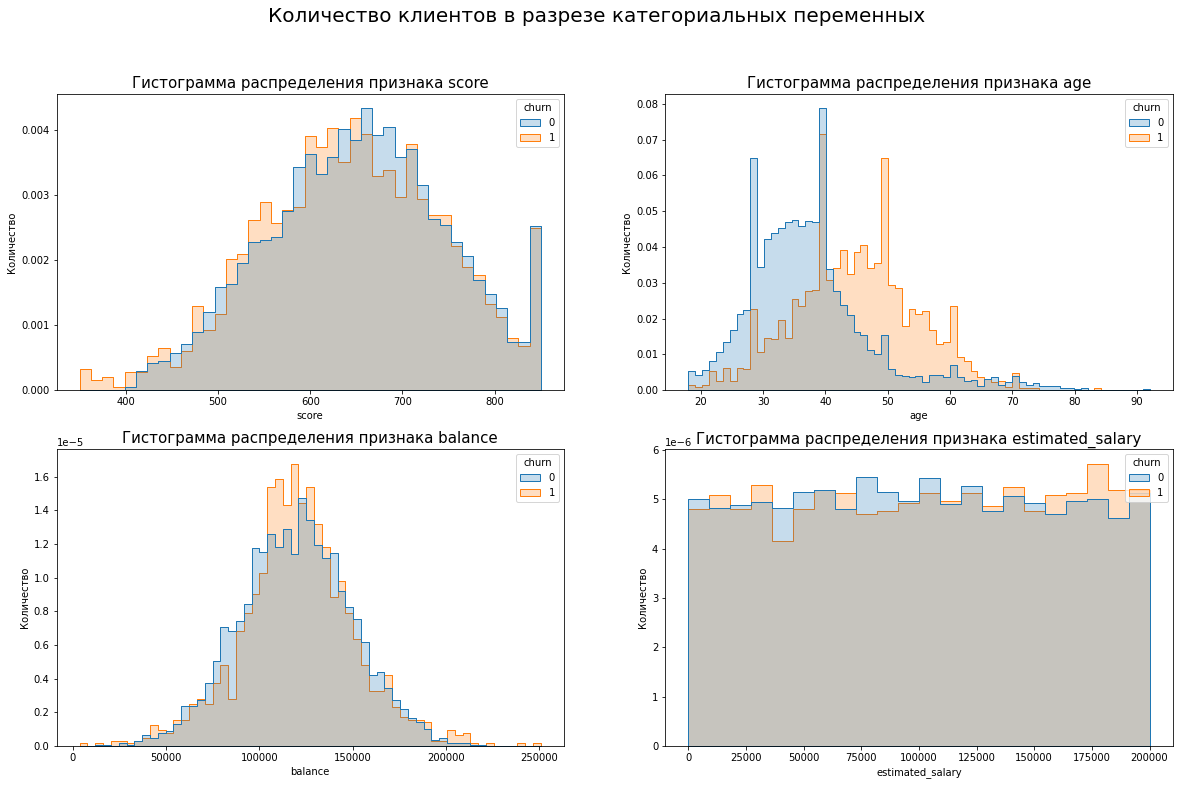

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.flatten()
for col, subplot in zip(numeric, ax):
    sns.histplot(df, x=col, ax=subplot, hue="churn", element="step", stat="density", common_norm=False)
    subplot.set_ylabel('Количество')
    subplot.set_xlabel(col)
    subplot.set_title('Гистограмма распределения признака {}'. format(col), size=15)
fig.suptitle("Количество клиентов в разрезе категориальных переменных", size=20)

**Вывод:** 
* Чаще уходят из банка клиенты с более низким кредитным рейтингом, хотя в цифрах эта разница не значительна - в среднем это 6.5 кредитных балов.
* Чем старше клиент, тем больше вероятность его ухода - средний возраст 45 лет, против 37 лет у оставшихся.
* По балансу на счете нет сильной разницы. Разве что у остающихся клиентов график имеет более равномерное распределение.
* Зарплата у тех, кто уходит немного выше (~ 1700 рублей).

Text(0.5, 0.98, 'Количество клиентов в разрезе колличественных переменных')

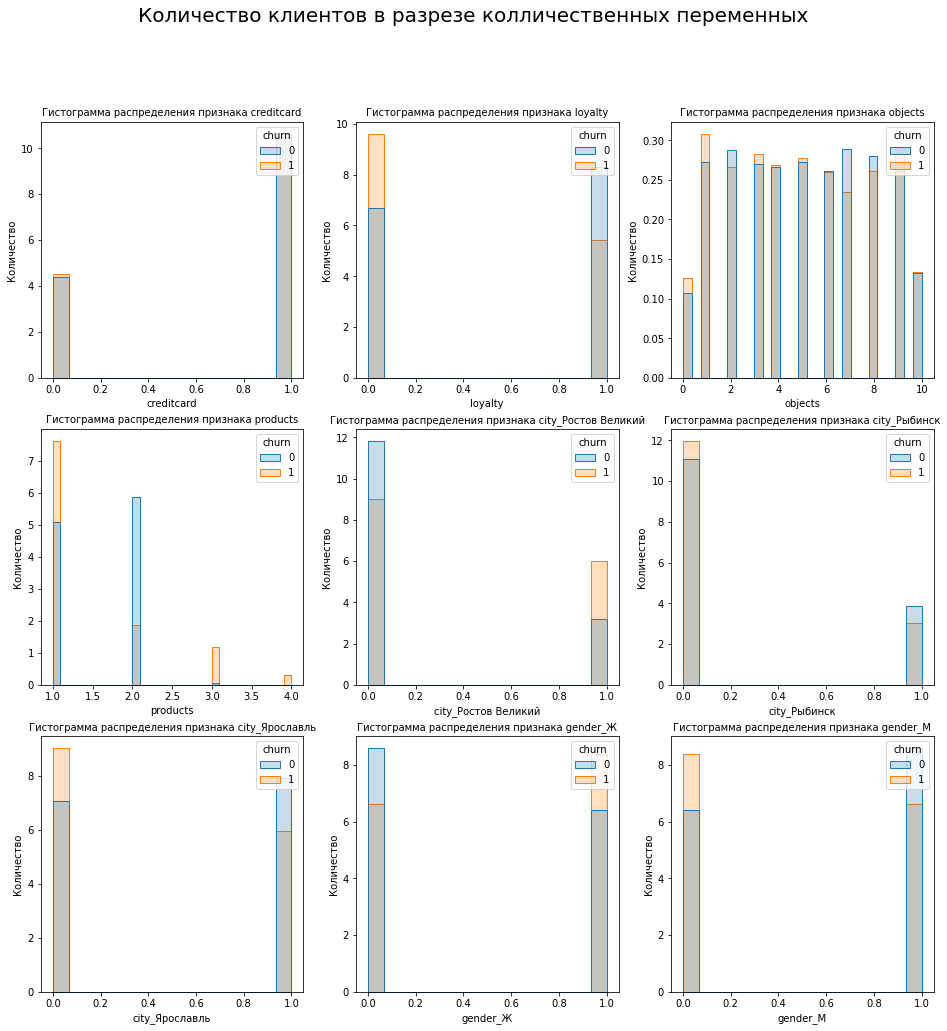

In [19]:
fig, ax = plt.subplots(3,3, figsize=(16, 16))
ax = ax.flatten()
for col, subplot in zip(categorical, ax):
    sns.histplot(df, x=col, ax=subplot, hue="churn", element="step", stat="density", common_norm=False)
    subplot.set_ylabel('Количество')
    subplot.set_xlabel(col)
    subplot.set_title('Гистограмма распределения признака {}'. format(col), size=10)
fig.suptitle("Количество клиентов в разрезе колличественных переменных", size=20)

**Вывод:**
* Обе группы в равной мере пользуются кредитными картами.
* Среди оставшихся клиентов, доля активных больше - 55% против 45% неактивных. В группе ушедших ситуация другая - 34% активных против 64% неактивных.
* Ситуация более менее схожа. Чем большим количеством объектов владеют клиенты, там меньше вероятность их оттока.
* По количеству человек, чаще всего уходят клиенты, пользующиеся 1 продуктом. Но также можно сказать, что с вероятностью 90-100% уходят клиенты, у которых 3-4 продукта в пользовании. Менее всего подвержены оттоку клиенты с 2 продуктами.
* В Ростове Великом самая высокая динамика оттока клиентов.
* В Рыбинске, как и в Ярославле динамика удержания пока что в норме - отток не превышает удержание.
* Женщины более склонны уходить - почти 60% покидают банк.
* С мужчинами ситуация лучше - более 57% остаются.

### Корреляционный анализ

Проведем корреляционный анализ.

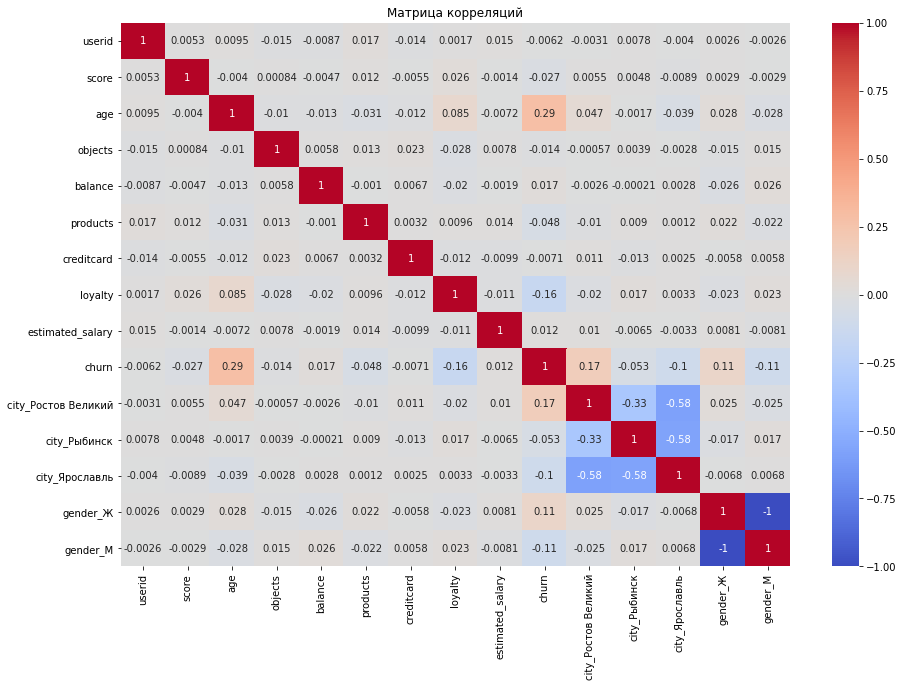

In [20]:
plt.figure(figsize=(15,10))

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title('Матрица корреляций')
plt.show()

**Вывод:**
* Мультиколлинеарных признаков не наблюдается.
* Наиболее сильное влияние на отток оказывают:
    * возраст клиентов - `0.29`;
    * город (особенно Ростов Великий) - `0.17`;
    * активность клиентов -  `-0.16`; причем здесь наблюдается именно обратная корреляция, т.е. чем больше активность, тем меньше отток;
    * пол клиентов - `0.11` (одинаково для обоих гендеров); для женщин - прямая зависимость, а для мужчин обратная;
    
В общем и в целом нельзя сказать о какой-то сильной зависимости признаков. Тем не менее, стоит проверить возраст клиентов в дальнейшем при проверке гипоттез, как фактор влияния на отток.

## Портрет клиентов, склонных уходить из банка

На основе проведенного исследовательского анализа составим портреты клиентов, которые склонны уходить, а также тех, кто остается.

**Портрет клиентов, склонных к оттоку**
* В основном женщины;
* Средний возраст - 45 лет;
* Город проживания - Ростов Великий;
* Низкое проявление активности;
* Средняя зарплата 99 738 рублей;
* В среднем имеют меньше 5 объектов в собственности;
* Средний кредитный рейтинг 645;
* В основном пользуются 1 продуктом, плюс 100% отток у тех, кто пользуется 4 продуктами;
* Пользуются кредитными картами.

**Портрет клиентов, несклонных к оттоку**
* В основном мужчины;
* Средний возраст - 37 лет;
* Город проживания - Ярославль и Рыбинск;
* Высокое проявление активности;
* Средняя зарплата 101 465 рублей;
* В среднем имеют больше 5 объектов в собственности;
* Средний кредитный рейтинг 651;
* В основном пользуются 2 продуктами;
* Пользуются кредитными картами.

## Формулировка и проверка гипотез

### Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались

**Нулевая гипотеза:** доход клиентов, которые ушли равен доходу оставшихся клиентов.

**Альтернативная гипотеза:** доход клиентов, которые ушли и доход оставшихся клиентов различаются. 

Поскольку мы имеем дело со средними, то применим метод проверки гипотезы о равенстве двух средних. Для проверки подойдёт t-test(тест Стьюдента).

In [21]:
# подготовим выборки
df_churn_1 = df[df['churn']==1]['estimated_salary'] # для тех, кто ушел
df_churn_0 = df[df['churn']==0]['estimated_salary'] # для тех, кто остался

Определим равны ли выборки по количеству значений.

In [22]:
print(
    F"Размеры выборок составляют:\n для попавших в отток - {df_churn_1.count()}"
    F"\n для оставшихся в банке - {df_churn_0.count()}"
)

Размеры выборок составляют:
 для попавших в отток - 2037
 для оставшихся в банке - 7963


Так как выбороки имеют разные размеры, установим значение параметра `equal_var` равное  `False`

In [23]:
# зададим критический уровень статистической значимости равным 5%
alpha = 0.05

results = st.ttest_ind(df_churn_1, df_churn_0, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22892461305145798
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

Не получилось отвергнуть нулевую гипотезу: нельзя сказать о том, что разница между средними значениями статистически значима.

### Гипотеза различия возраста между теми клиентами, которые ушли и теми, которые остались

**Нулевая гипотеза:** возраст клиентов, которые ушли равен возрасту оставшихся клиентов.

**Альтернативная гипотеза:** возраст клиентов, которые ушли и возраст оставшихся клиентов различаются. 

In [24]:
# подготовим выборки
df_age_1 = df[df['churn']==1]['age'] # для тех, кто ушел
df_age_0 = df[df['churn']==0]['age'] # для тех, кто остался

Размер выборок для признака "возраст" равен размеру выборки для признака "доход", поэтому параметр `equal_var` оставляем  `False`

In [25]:
alpha = 0.05

results = st.ttest_ind(df_age_1, df_age_0, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение: 4.7127272656641046e-179
Отвергаем нулевую гипотезу.


**Вывод:**

Отвергаем нулевую гипотезу. Значит между средним возрастом ушедших и оставшихся клиентов имеется статистически значимая разница.

## Общий вывод и рекомендации

1\. В процессе **загрузки и предобработки** было определено, что датасет состоит из 12 столбцов и 10 000 строк. Выполнены следующий действия:
* Названия столбцов приведены к единому регистру - нижнему.
* Пропуски, обнаруженные по столбцу `balance`, было принято решение не трогать.
* Заменены типы данных в столбцах `gender` и `city`.

2\. В результате **исследовательского анализа EDA** были определены портреты клиентов:

**Портрет клиентов, склонных к оттоку**
* В основном женщины;
* Средний возраст - 45 лет;
* Город проживания - Ростов Великий;
* Низкое проявление активности;
* Средняя зарплата 99 738 рублей;
* В среднем имеют меньше 5 объектов в собственности;
* Средний кредитный рейтинг 645;
* В основном пользуются 1 продуктом, плюс 100% отток у тех, кто пользуется 4 продуктами;
* Пользуются кредитными картами.

**Портрет клиентов, несклонных к оттоку**
* В основном мужчины;
* Средний возраст - 37 лет;
* Город проживания - Ярославль и Рыбинск;
* Высокое проявление активности;
* Средняя зарплата 101 465 рублей;
* В среднем имеют больше 5 объектов в собственности;
* Средний кредитный рейтинг 651;
* В основном пользуются 2 продуктами;
* Пользуются кредитными картами.

3\. В процессе **проверки гипотез**:

* не получилось отвергнуть гипотезу `о различии дохода между теми клиентами, которые ушли и теми, которые остались`, так как нельзя сказать, что разница между средними значениями статистически значима;
* была отвергнута гипотеза `о равенстве возраста ушедших и оставшихся клиентов`, что означает наличие статистически значимой разницы между средним возрастом ушедших и оставшихся клиентов.


**Рекомендации:**
1. В первую очередь обратить внимание на клиентов старшей возрастной группы. Как вариант, предлагать комплексные предложения, например дебетовые карты с повышенным кэшбеком в аптеках и на остаток баланса карты. Также будет неплохим подспорьем увеличить процентную ставку на вклады, т.к. пенсионеры склонны откладывать деньги.
2. Провести разбор оттока клиентов в городе Ростов Великий. Возможно банки-конкуренты предлагают лучшие условия обслуживания. 
3. Необходимо повысить активность клиентов. Как именно: внедрение различных бонусных программ при пользовании продуктами банка, оповещать об интересных событиях и акциях путем смс-информирования и push-уведомлений, возможно доработать приложение банка - повысить удобство пользования и качество работы.
4. Улучшить отдельные кредитные условия для клиентов-женщин. Возможно необходимо проработать смягчение требований к получению займов.